In [1]:
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import numpy
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
# Parameters. Choose the stock for the analysis. Also choose the delta_time of the prediction 
# (look_back variable, if you want to predict one day, two days, etc...). Here we chose Google stock price. 

companies = 'GOOG'
look_back = 1

In [3]:
# This function retrieves the closing price of the stock. 

def get_historical_close_data(name):
    url = "https://www.google.com/finance/historical?q=%s&startdate=01-Jan-2000&output=csv"%name
    
    data = pd.read_csv(url)
    data = data.loc[:,('Date','Close')]
    data = data.sort_index(ascending = False)
    return data

In [4]:
# This function normalizes the data (using min max sklearn package). We can achieve better predictions using normalized 
# data. After making the prediciton, we "undo" the normalization using the de_normalization function.


def normalization(data):
    scaler = MinMaxScaler(feature_range = (0,1))
    data_norm = scaler.fit_transform(data)
    
    return data_norm

def de_normalization(data, new_data):
    scaler = MinMaxScaler(feature_range = (0,1))
    scaler.fit_transform(data)
    unormalized = scaler.inverse_transform(new_data)
    
    return unormalized

In [5]:
# Time Series train test split is different from the usual split. We cannot select randomly because the sequence of
# information presented by the time series is important. In this case, we will use the first 2/3 of the data set 
# as training set, and the other 1/3 data set as testing set. Later, we will use other methods for comparison. 


def split_train_test(data):
    

    # split into train and test sets
    train_size = int(len(data) * 0.67)
    train, test = data[0:train_size,], data[train_size:len(data),]
    return train, test


In [6]:
# This function creates a dataset with two series, the first one is our database (series of prices), and the second one 
# is the same database that will be predicted. This second database is our price list moved one day ahead (look_back variable)


def create_dataset(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset)-lookback-1):
        a = dataset[i:(i+lookback), ]
        dataX.append(a)
        dataY.append(dataset[i + lookback, ])
    return numpy.array(dataX), numpy.array(dataY)


In [7]:
# Here we have the code to retrieve and work the dataset, using the functions defined above. 

dataset = get_historical_close_data(companies)

dataset_norm = normalization(dataset['Close'].values.reshape(-1,1))

train_dataset, test_dataset = split_train_test(dataset_norm)

train_X, train_y = create_dataset(train_dataset, look_back)

test_X, test_y = create_dataset(test_dataset,look_back)


In [8]:
# We are going to reshape the X set because the LSTM cells of the tensorflow receives as input the 
# [samples, timesteps, features]
train_X = numpy.reshape(train_X, (train_X.shape[0], 1 , train_X.shape[1]))
test_X = numpy.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))


In [10]:
# Now let's go to the model. First we stablish our model as a sequential one (time series). Than we add four Long Short
# Term Memories, one Dense Layer (it is used change the dimension of the vector), The compile with a loss function and
# an optimizer and finally, the fit function, with 3 epochs (more than that we fall into over training). 

model = Sequential()
model.add(LSTM(32, input_shape=(None,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_X, train_y, epochs=3, batch_size=1, verbose=2)

Epoch 1/3
27s - loss: 0.0010
Epoch 2/3
25s - loss: 3.6086e-05
Epoch 3/3
25s - loss: 3.7248e-05


In [11]:
# Now lets make the predictions of the normalized data.
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)

In [12]:
# Revert the predictions from normalized to regular values

trainPredict = de_normalization(dataset['Close'].values.reshape(-1,1), trainPredict)
train_y = de_normalization(dataset['Close'].values.reshape(-1,1),train_y)
testPredict = de_normalization(dataset['Close'].values.reshape(-1,1), testPredict)
test_y = de_normalization(dataset['Close'].values.reshape(-1,1),test_y)

In [13]:
# Now lets compute the mean squared error.
trainScore = math.sqrt(mean_squared_error(train_y, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test_y, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 4.87 RMSE
Test Score: 16.71 RMSE


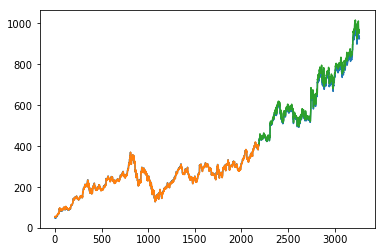

In [14]:


# Now let's plot the results. In blue we have the data, in green the training period, and in red our prediction
trainPredictPlot = numpy.empty_like(dataset_norm)
trainPredictPlot[:, ] = numpy.nan

trainPredictPlot[look_back:len(trainPredict)+look_back, ] = trainPredict[:,0].reshape(-1,1)
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset_norm)
testPredictPlot[:,] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset['Close'])-1, ] = testPredict[:,0].reshape(-1,1)
# plot baseline and predictions.reshape(-1,1)
plt.plot(de_normalization(dataset['Close'].values.reshape(-1,1),dataset_norm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

